<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/07_pytorch_experiment_tracking_exercise_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07. PyTorch Experiment Tracking Exercise Template(这一讲的内容是对比试验)

Welcome to the 07. PyTorch Experiment Tracking exercise template notebook.

> **Note:** There may be more than one solution to each of the exercises. This notebook only shows one possible example.

## Resources

1. These exercises/solutions are based on [section 07. PyTorch Transfer Learning](https://www.learnpytorch.io/07_pytorch_experiment_tracking/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/cO_r2FYcAjU).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

We'll need to make sure we have `torch` v.1.12+ and `torchvision` v0.13+.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    # !pip3 install -U --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
torch version: 2.9.1+cu128
torchvision version: 0.24.1+cu128


In [2]:
# Make sure we have a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Get regular imports 
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [5]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [7]:
# Create a test writer
writer = create_writer(experiment_name="test_experiment_name",
                       model_name="this_is_the_model_name",
                       extra="add_a_little_extra_if_you_want")

[INFO] Created SummaryWriter, saving to: runs/2025-12-25/test_experiment_name/this_is_the_model_name/add_a_little_extra_if_you_want...


In [8]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step


# 区别：之前的exercise定义的train函数都是把结果存进了一堆数组，然后一起扔进字典里
# 这里则考虑把结果格式化并放进tensorboard的writer类里面
# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

### Download data

Using the same data from https://www.learnpytorch.io/07_pytorch_experiment_tracking/

In [9]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [10]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [11]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

# Create a transform pipeline
simple_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(), # get image values between 0 & 1
                                       normalize
])

### Turn data into DataLoaders 

In [12]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


## Exercise 1: Pick a larger model from [`torchvision.models`](https://pytorch.org/vision/main/models.html) to add to the list of experiments (for example, EffNetB3 or higher)

* How does it perform compared to our existing models?
* **Hint:** You'll need to set up an exerpiment similar to [07. PyTorch Experiment Tracking section 7.6](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#76-create-experiments-and-set-up-training-code).

In [13]:
# create models
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2,inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES).to(device)
    )
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

def create_effnetb3():
    weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
    model = torchvision.models.efficientnet_b3(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2,inplace=True),
        nn.Linear(in_features=1536, out_features=OUT_FEATURES).to(device)
    )
    model.name = "effnetb3"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [14]:
effnetb2 = create_effnetb2()
effnetb3 = create_effnetb3()

[INFO] Created new effnetb2 model.
[INFO] Created new effnetb3 model.


In [15]:
# Sanity check classifier in_features to avoid shape mismatches
print('effnetb2 classifier in_features:', effnetb2.classifier[1].in_features)
print('effnetb3 classifier in_features:', effnetb3.classifier[1].in_features)
print('Expected OUT_FEATURES:', OUT_FEATURES)

effnetb2 classifier in_features: 1408
effnetb3 classifier in_features: 1536
Expected OUT_FEATURES: 3


In [16]:
from torchinfo import summary

summary(model=effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        device=device)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [19]:
num_epochs = [5, 10]
models = ["effnetb2", "effnetb3"]

train_dataloaders = {"data_10_percent" : train_dataloader_10_percent,
                     "data_20_percent" : train_dataloader_20_percent}

In [20]:

from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number = experiment_number + 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb2":
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb3() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-12-25/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0921 | train_acc: 0.3789 | test_loss: 0.9547 | test_acc: 0.6809
Epoch: 2 | train_loss: 0.9200 | train_acc: 0.6680 | test_loss: 0.8626 | test_acc: 0.8040
Epoch: 2 | train_loss: 0.9200 | train_acc: 0.6680 | test_loss: 0.8626 | test_acc: 0.8040
Epoch: 3 | train_loss: 0.8138 | train_acc: 0.7188 | test_loss: 0.7354 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.8138 | train_acc: 0.7188 | test_loss: 0.7354 | test_acc: 0.9688
Epoch: 4 | train_loss: 0.7026 | train_acc: 0.8906 | test_loss: 0.7026 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.7026 | train_acc: 0.8906 | test_loss: 0.7026 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6685 | train_acc: 0.8008 | test_loss: 0.6987 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb3
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
Epoch: 5 | train_loss: 0.6685 | train_acc: 0.8008 |

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0603 | train_acc: 0.4102 | test_loss: 1.0235 | test_acc: 0.6402
Epoch: 2 | train_loss: 0.9285 | train_acc: 0.6641 | test_loss: 0.9189 | test_acc: 0.6932
Epoch: 2 | train_loss: 0.9285 | train_acc: 0.6641 | test_loss: 0.9189 | test_acc: 0.6932
Epoch: 3 | train_loss: 0.7875 | train_acc: 0.8555 | test_loss: 0.7573 | test_acc: 0.8750
Epoch: 3 | train_loss: 0.7875 | train_acc: 0.8555 | test_loss: 0.7573 | test_acc: 0.8750
Epoch: 4 | train_loss: 0.6917 | train_acc: 0.8125 | test_loss: 0.6895 | test_acc: 0.9062
Epoch: 4 | train_loss: 0.6917 | train_acc: 0.8125 | test_loss: 0.6895 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.6577 | train_acc: 0.8359 | test_loss: 0.6441 | test_acc: 0.9271
[INFO] Saving model to: models/07_effnetb3_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0921 | train_acc: 0.3789 | test_loss: 0.9547 | test_acc: 0.6809
Epoch: 2 | train_loss: 0.9200 | train_acc: 0.6680 | test_loss: 0.8626 | test_acc: 0.8040
Epoch: 2 | train_loss: 0.9200 | train_acc: 0.6680 | test_loss: 0.8626 | test_acc: 0.8040
Epoch: 3 | train_loss: 0.8138 | train_acc: 0.7188 | test_loss: 0.7354 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.8138 | train_acc: 0.7188 | test_loss: 0.7354 | test_acc: 0.9688
Epoch: 4 | train_loss: 0.7026 | train_acc: 0.8906 | test_loss: 0.7026 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.7026 | train_acc: 0.8906 | test_loss: 0.7026 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6685 | train_acc: 0.8008 | test_loss: 0.6987 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.6685 | train_acc: 0.8008 | test_loss: 0.6987 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6013 | train_acc: 0.7891 | test_loss: 0.6244 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.6013 | train_acc: 0.7891 | test_loss: 0.6244 | test_acc: 0.9280
Epoch: 7 | train_loss

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0603 | train_acc: 0.4102 | test_loss: 1.0235 | test_acc: 0.6402
Epoch: 2 | train_loss: 0.9285 | train_acc: 0.6641 | test_loss: 0.9189 | test_acc: 0.6932
Epoch: 2 | train_loss: 0.9285 | train_acc: 0.6641 | test_loss: 0.9189 | test_acc: 0.6932
Epoch: 3 | train_loss: 0.7875 | train_acc: 0.8555 | test_loss: 0.7573 | test_acc: 0.8750
Epoch: 3 | train_loss: 0.7875 | train_acc: 0.8555 | test_loss: 0.7573 | test_acc: 0.8750
Epoch: 4 | train_loss: 0.6917 | train_acc: 0.8125 | test_loss: 0.6895 | test_acc: 0.9062
Epoch: 4 | train_loss: 0.6917 | train_acc: 0.8125 | test_loss: 0.6895 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.6577 | train_acc: 0.8359 | test_loss: 0.6441 | test_acc: 0.9271
Epoch: 5 | train_loss: 0.6577 | train_acc: 0.8359 | test_loss: 0.6441 | test_acc: 0.9271
Epoch: 6 | train_loss: 0.6551 | train_acc: 0.7461 | test_loss: 0.6022 | test_acc: 0.9062
Epoch: 6 | train_loss: 0.6551 | train_acc: 0.7461 | test_loss: 0.6022 | test_acc: 0.9062
Epoch: 7 | train_loss

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9725 | train_acc: 0.5458 | test_loss: 0.7707 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7219 | train_acc: 0.8229 | test_loss: 0.6527 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.7219 | train_acc: 0.8229 | test_loss: 0.6527 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.5944 | train_acc: 0.8229 | test_loss: 0.5531 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5944 | train_acc: 0.8229 | test_loss: 0.5531 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.5244 | train_acc: 0.8271 | test_loss: 0.5586 | test_acc: 0.8873
Epoch: 4 | train_loss: 0.5244 | train_acc: 0.8271 | test_loss: 0.5586 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.4228 | train_acc: 0.8958 | test_loss: 0.4362 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb3
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
Epoch: 5 | train_loss: 0.4228 | train_acc: 0.8958 |

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9804 | train_acc: 0.6021 | test_loss: 0.8493 | test_acc: 0.8352
Epoch: 2 | train_loss: 0.7551 | train_acc: 0.7875 | test_loss: 0.6496 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.7551 | train_acc: 0.7875 | test_loss: 0.6496 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.5587 | train_acc: 0.9104 | test_loss: 0.5624 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.5587 | train_acc: 0.9104 | test_loss: 0.5624 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.5128 | train_acc: 0.8625 | test_loss: 0.5253 | test_acc: 0.8655
Epoch: 4 | train_loss: 0.5128 | train_acc: 0.8625 | test_loss: 0.5253 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.4289 | train_acc: 0.8917 | test_loss: 0.4632 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb3_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9725 | train_acc: 0.5458 | test_loss: 0.7707 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7219 | train_acc: 0.8229 | test_loss: 0.6527 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.7219 | train_acc: 0.8229 | test_loss: 0.6527 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.5944 | train_acc: 0.8229 | test_loss: 0.5531 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5944 | train_acc: 0.8229 | test_loss: 0.5531 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.5244 | train_acc: 0.8271 | test_loss: 0.5586 | test_acc: 0.8873
Epoch: 4 | train_loss: 0.5244 | train_acc: 0.8271 | test_loss: 0.5586 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.4228 | train_acc: 0.8958 | test_loss: 0.4362 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.4228 | train_acc: 0.8958 | test_loss: 0.4362 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.3797 | train_acc: 0.9125 | test_loss: 0.4527 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.3797 | train_acc: 0.9125 | test_loss: 0.4527 | test_acc: 0.9280
Epoch: 7 | train_loss

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9804 | train_acc: 0.6021 | test_loss: 0.8493 | test_acc: 0.8352
Epoch: 2 | train_loss: 0.7551 | train_acc: 0.7875 | test_loss: 0.6496 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.7551 | train_acc: 0.7875 | test_loss: 0.6496 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.5587 | train_acc: 0.9104 | test_loss: 0.5624 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.5587 | train_acc: 0.9104 | test_loss: 0.5624 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.5128 | train_acc: 0.8625 | test_loss: 0.5253 | test_acc: 0.8655
Epoch: 4 | train_loss: 0.5128 | train_acc: 0.8625 | test_loss: 0.5253 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.4289 | train_acc: 0.8917 | test_loss: 0.4632 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.4289 | train_acc: 0.8917 | test_loss: 0.4632 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.4287 | train_acc: 0.8771 | test_loss: 0.4703 | test_acc: 0.8352
Epoch: 6 | train_loss: 0.4287 | train_acc: 0.8771 | test_loss: 0.4703 | test_acc: 0.8352
Epoch: 7 | train_loss

## Exercise 2. Introduce data augmentation to the list of experiments using the 20% pizza, steak, sushi training and test datasets, does this change anything?
    
* For example, you could have one training DataLoader that uses data augmentation (e.g. `train_dataloader_20_percent_aug` and `train_dataloader_20_percent_no_aug`) and then compare the results of two of the same model types training on these two DataLoaders.
* **Note:** You may need to alter the `create_dataloaders()` function to be able to take a transform for the training data and the testing data (because you don't need to perform data augmentation on the test data). See [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) for examples of using data augmentation or the script below for an example:

epoch_options = [5, 10]
models = ["effnetb2", "effnetb3"]

train_dataloaders = {"data_10_percent" : train_dataloader_10_percent,
                     "data_20_percent" : train_dataloader_20_percent}
```python
# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Create a helper function to visualize different augmented (and not augmented) images
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

# Have to update `create_dataloaders()` to handle different augmentations
import os
from torch.utils.data import DataLoader
from torchvision import datasets

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data 

# Note: this is an update version of data_setup.create_dataloaders to handle
# differnt train and test transforms.
def create_dataloaders(
    train_dir, 
    test_dir, 
    train_transform, # add parameter for train transform (transforms on train dataset)
    test_transform,  # add parameter for test transform (transforms on test dataset)
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names
```

In [30]:
# Create a data augmentation transfrom
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

data_aug_transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Create a non-data aug transform
no_data_aug_transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    normalize
])

In [31]:
# update dataloader

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_transform: transforms.Compose, ### New (only want to do data augmentation on the training dataset)
    test_transform: transforms.Compose, ### New
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, 
                                    transform=train_transform) ### New
  test_data = datasets.ImageFolder(test_dir, 
                                   transform=test_transform) ### New

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

# Visulize different samples from both dataloaders (aug and no aug)
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

In [32]:
# Create train and test directories
train_20_percent_dir = image_path / "train"
test_20_percent_dir = image_path / "test"

BATCH_SIZE = 32

# Create train dataloader *with* data augmentation
train_dataloader_20_percent_with_aug, test_dataloader_20_percent, class_names = create_dataloaders(train_dir=train_20_percent_dir,
                                                                                                   test_dir=test_20_percent_dir,
                                                                                                   train_transform=data_aug_transform,
                                                                                                   test_transform=no_data_aug_transform,
                                                                                                   batch_size=BATCH_SIZE)

# Create train dataloader *without* data augmentation
train_dataloader_20_percent_without_aug, test_dataloader_20_percent, class_names = create_dataloaders(train_dir=train_20_percent_dir,
                                                                                                   test_dir=test_20_percent_dir,
                                                                                                   train_transform=no_data_aug_transform,
                                                                                                   test_transform=no_data_aug_transform,
                                                                                                   batch_size=BATCH_SIZE)

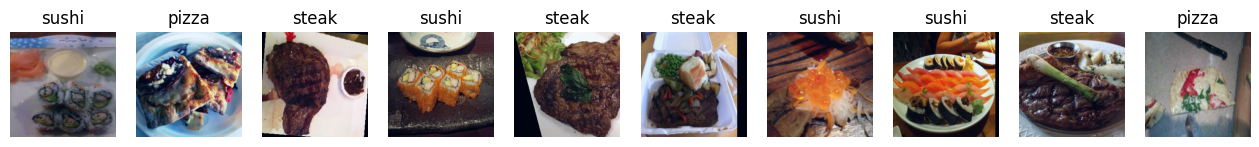

In [33]:
view_dataloader_images(train_dataloader_20_percent_with_aug)

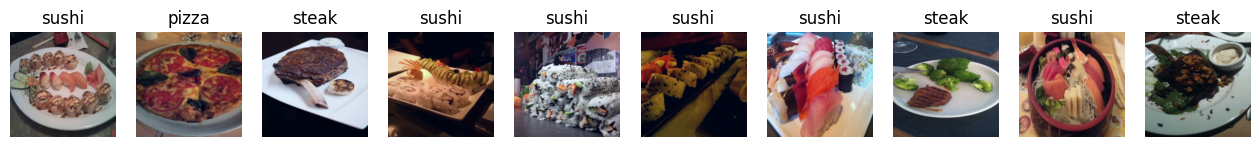

In [34]:
view_dataloader_images(train_dataloader_20_percent_without_aug)

In [35]:
# Setup number of epochs
num_epochs = [5, 10]

# Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_20_percent_with_aug": train_dataloader_20_percent_with_aug,
                     "data_20_percent_without_aug": train_dataloader_20_percent_without_aug}

# Create model
models = ["effnetb2"]

In [36]:

from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb2":
              model = create_effnetb2()
            else:
              model = create_effnetb2()

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.002)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader_20_percent, ### New, use test_dataloader_20_percent
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent_with_aug
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-12-25/data_20_percent_with_aug/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0346 | train_acc: 0.4219 | test_loss: 0.9134 | test_acc: 0.6316
Epoch: 2 | train_loss: 0.8598 | train_acc: 0.6719 | test_loss: 0.6490 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.8598 | train_acc: 0.6719 | test_loss: 0.6490 | test_acc: 0.8665
Epoch: 3 | train_loss: 0.7758 | train_acc: 0.6797 | test_loss: 0.5246 | test_acc: 0.8968
Epoch: 3 | train_loss: 0.7758 | train_acc: 0.6797 | test_loss: 0.5246 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.5599 | train_acc: 0.8867 | test_loss: 0.5715 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.5599 | train_acc: 0.8867 | test_loss: 0.5715 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.6487 | train_acc: 0.7500 | test_loss: 0.5448 | test_acc: 0.8665
[INFO] Saving model to: models/07_effnetb2_data_20_percent_with_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent_with_aug
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 mode

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0346 | train_acc: 0.4219 | test_loss: 0.9134 | test_acc: 0.6316
Epoch: 2 | train_loss: 0.8598 | train_acc: 0.6719 | test_loss: 0.6490 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.8598 | train_acc: 0.6719 | test_loss: 0.6490 | test_acc: 0.8665
Epoch: 3 | train_loss: 0.7758 | train_acc: 0.6797 | test_loss: 0.5246 | test_acc: 0.8968
Epoch: 3 | train_loss: 0.7758 | train_acc: 0.6797 | test_loss: 0.5246 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.5599 | train_acc: 0.8867 | test_loss: 0.5715 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.5599 | train_acc: 0.8867 | test_loss: 0.5715 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.6487 | train_acc: 0.7500 | test_loss: 0.5448 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.6487 | train_acc: 0.7500 | test_loss: 0.5448 | test_acc: 0.8665
Epoch: 6 | train_loss: 0.5238 | train_acc: 0.7891 | test_loss: 0.4180 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5238 | train_acc: 0.7891 | test_loss: 0.4180 | test_acc: 0.8968
Epoch: 7 | train_loss

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0364 | train_acc: 0.4414 | test_loss: 0.8938 | test_acc: 0.6525
Epoch: 2 | train_loss: 0.8051 | train_acc: 0.6797 | test_loss: 0.6278 | test_acc: 0.8977
Epoch: 2 | train_loss: 0.8051 | train_acc: 0.6797 | test_loss: 0.6278 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.7123 | train_acc: 0.7461 | test_loss: 0.4981 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.7123 | train_acc: 0.7461 | test_loss: 0.4981 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.4944 | train_acc: 0.9062 | test_loss: 0.5335 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.4944 | train_acc: 0.9062 | test_loss: 0.5335 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.5586 | train_acc: 0.8008 | test_loss: 0.5444 | test_acc: 0.8570
[INFO] Saving model to: models/07_effnetb2_data_20_percent_without_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent_without_aug
[INFO] Number of epochs: 10
Epoch: 5 | train_loss: 0.5

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0364 | train_acc: 0.4414 | test_loss: 0.8938 | test_acc: 0.6525
Epoch: 2 | train_loss: 0.8051 | train_acc: 0.6797 | test_loss: 0.6278 | test_acc: 0.8977
Epoch: 2 | train_loss: 0.8051 | train_acc: 0.6797 | test_loss: 0.6278 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.7123 | train_acc: 0.7461 | test_loss: 0.4981 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.7123 | train_acc: 0.7461 | test_loss: 0.4981 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.4944 | train_acc: 0.9062 | test_loss: 0.5335 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.4944 | train_acc: 0.9062 | test_loss: 0.5335 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.5586 | train_acc: 0.8008 | test_loss: 0.5444 | test_acc: 0.8570
Epoch: 5 | train_loss: 0.5586 | train_acc: 0.8008 | test_loss: 0.5444 | test_acc: 0.8570
Epoch: 6 | train_loss: 0.4460 | train_acc: 0.7969 | test_loss: 0.4217 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4460 | train_acc: 0.7969 | test_loss: 0.4217 | test_acc: 0.9280
Epoch: 7 | train_loss

## Exercise 3. Scale up the dataset to turn FoodVision Mini into FoodVision Big using the entire [Food101 dataset from `torchvision.models`](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101)
    
* You could take the best performing model from your various experiments or even the EffNetB2 feature extractor we created in this notebook and see how it goes fitting for 5 epochs on all of Food101.
* If you try more than one model, it would be good to have the model's results tracked.
* If you load the Food101 dataset from `torchvision.models`, you'll have to create PyTorch DataLoaders to use it in training.
* **Note:** Due to the larger amount of data in Food101 compared to our pizza, steak, sushi dataset, this model will take longer to train.

这个数据集确实有点大（有5G左右），电脑空间有点不够，而且思想已经get到了，在这里不展示。